# An agent from langchain that can analyze images and text

Made with inspiration from this source code from langchain:

https://python.langchain.com/docs/how_to/document_loader_pdf/#use-of-multimodal-models

In [169]:
# Install the necessary libraries
# uncomment the following lines to install the necessary libraries

# pip install fitz pillow

In [170]:
import base64
import io
import fitz
from PIL import Image
from IPython.display import Image as IPImage, display
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
from pydantic import BaseModel, Field
from typing import Optional, List

def pdf_page_to_base64(pdf_path: str, page_number: int):
    pdf_document = fitz.open(pdf_path)
    page = pdf_document.load_page(page_number - 1)  # input is one-indexed
    pix = page.get_pixmap()
    img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)

    buffer = io.BytesIO()
    img.save(buffer, format="PNG")

    return base64.b64encode(buffer.getvalue()).decode("utf-8")

def get_pdf_content(pdf_path: str) -> dict:
    pdf_document = fitz.open(pdf_path)
    text = []
    for page_num in range(len(pdf_document)):
        page = pdf_document.load_page(page_num)
        text.append(page.get_text())
    return text

# Get the content of the PDF file
pdf_text = get_pdf_content("../../data/test_with_images.pdf")

# Path to the PDF file
pdf_path = "../../data/test_with_images.pdf"

# Initialize the multimodal model
llm = ChatOpenAI(model="gpt-4o-mini")

from pydantic import BaseModel, Field
from typing import List, Dict, Tuple

class Node(BaseModel):
    #id: str = Field(..., description="The unique identifier for the node.")
    label: str = Field(..., description="The label or name of the node.")

class Edge(BaseModel):
    sources: List[str] = Field(..., description="The IDs of the source nodes.")
    targets: List[str] = Field(..., description="The IDs of the target nodes.")
    weight: Optional[float] = Field(..., description="The weight or cost of the edge.")
    label: Optional[str] = Field(..., description="The label or description of the edge.")
    condition: Optional[str] = Field(..., description="The condition under which this edge is valid.")

class DiagramContent(BaseModel):
    title: str = Field(..., description="The title of the diagram.")
    description: str = Field(..., description="A brief description of the diagram.")
    nodes: List[Node] = Field(..., description="The nodes in the graph.")
    edges: List[Edge] = Field(..., description="The edges between the nodes in the graph.")
    diagram_type: str = Field(..., description="The type of diagram (e.g., flowchart, network graph).")

class TableContent(BaseModel):
    headers: List[str] = Field(..., description="The headers of the table.")
    rows: List[List[str]] = Field(..., description="The rows of the table.")

class ImageContentOutout(BaseModel):
    task: str = Field(..., description="The task being performed.")
    objective: str = Field(..., description="The objective of the task.")
    expected_result: str = Field(..., description="The expected result of the task.")
    tables: List[TableContent] = Field(..., description="The table information extracted from the document.")
    number_of_diagrams: int = Field(..., description="The number of diagrams in the document.")
    diagrams: List[DiagramContent] = Field(..., description="The detailed diagram information.")

llm_with_struct = llm.with_structured_output(ImageContentOutout)

In [171]:
def extract_image_info(page_num, context: Optional[str] = None):
    page_text = pdf_text[page_num - 1]
    base64_image = pdf_page_to_base64(pdf_path, page_num)
    display(IPImage(data=base64.b64decode(base64_image)))

    # Define the query
    query = f"""
    Analyze the content of page {page_num}
    Use this context: {context} if provided
    use the context and fill in the missing information
    """

    # Create the message with text and image
    message = HumanMessage(
        content=[
            {"type": "text", "text": query},
            {"type": "text", "text": page_text},
            {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"},
            },
        ],
    )
    # Query the model
    response = llm_with_struct.invoke([message])
    print(f"Page {page_num} analysis:\n{response}\n")
    return response

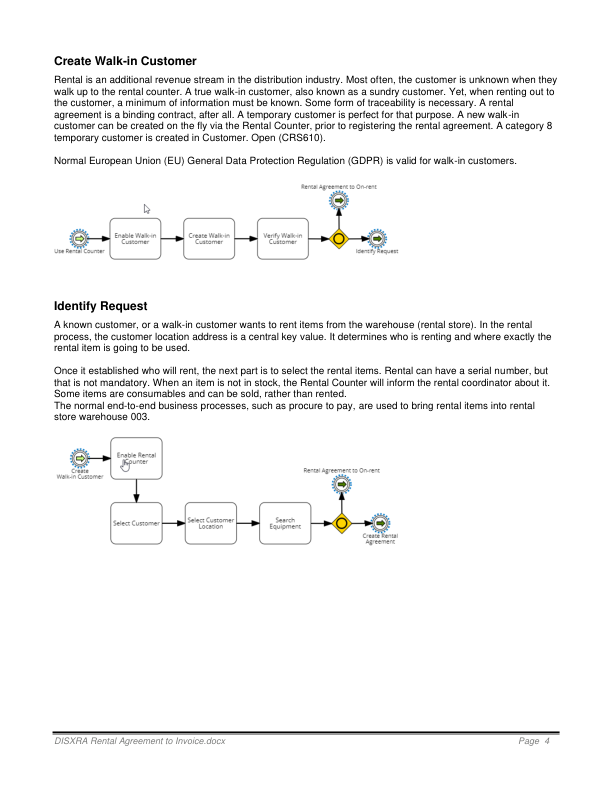

Page 4 analysis:
task='Analyze the content of page 4 of the rental agreement document.' objective='Identify the key processes involved in creating a walk-in customer and identifying rental requests.' expected_result='Summarize the steps required for walk-in customer creation and rental request identification, including necessary information and processes.' tables=[] number_of_diagrams=2 diagrams=[DiagramContent(title='Create Walk-in Customer Process', description='Flowchart demonstrating the steps to create a walk-in customer.', nodes=[Node(label='Use Rental Counter'), Node(label='Enable Walk-in Customer'), Node(label='Create Walk-in Customer'), Node(label='Verify Walk-in Customer'), Node(label='Identify Request')], edges=[Edge(sources=['Use Rental Counter'], targets=['Enable Walk-in Customer'], weight=None, label=None, condition=None), Edge(sources=['Enable Walk-in Customer'], targets=['Create Walk-in Customer'], weight=None, label=None, condition=None), Edge(sources=['Create Walk-in 

In [172]:
response = extract_image_info(4)

In [173]:
for index, gram in enumerate(response.diagrams):
    print(f"Diagram {index + 1}:")
    print(f"Title: {gram.title}")
    print(f"Description: {gram.description}")
    
    print("Nodes:")
    for node in gram.nodes:
        print(f"  - Node Label: {node.label}")
    
    print("Edges:")
    for edge in gram.edges:
        # Handle multiple sources and targets
        sources = ", ".join(edge.sources)
        targets = ", ".join(edge.targets)
        condition = f" (Condition: {edge.condition})" if edge.condition else ""
        
        print(f"  - Sources: {sources}")
        print(f"    Targets: {targets}")
        print(f"    Weight: {edge.weight}")
        print(f"    Label: {edge.label}{condition}")
    print("\n")

Diagram 1:
Title: Create Walk-in Customer Process
Description: Flowchart demonstrating the steps to create a walk-in customer.
Nodes:
  - Node Label: Use Rental Counter
  - Node Label: Enable Walk-in Customer
  - Node Label: Create Walk-in Customer
  - Node Label: Verify Walk-in Customer
  - Node Label: Identify Request
Edges:
  - Sources: Use Rental Counter
    Targets: Enable Walk-in Customer
    Weight: None
    Label: None
  - Sources: Enable Walk-in Customer
    Targets: Create Walk-in Customer
    Weight: None
    Label: None
  - Sources: Create Walk-in Customer
    Targets: Verify Walk-in Customer
    Weight: None
    Label: None
  - Sources: Verify Walk-in Customer
    Targets: Identify Request
    Weight: None
    Label: None


Diagram 2:
Title: Identify Request Process
Description: Flowchart outlining the steps needed to identify a customer's rental request.
Nodes:
  - Node Label: Walk-in Customer
  - Node Label: Enable Rental Customer
  - Node Label: Select Customer
  - Node

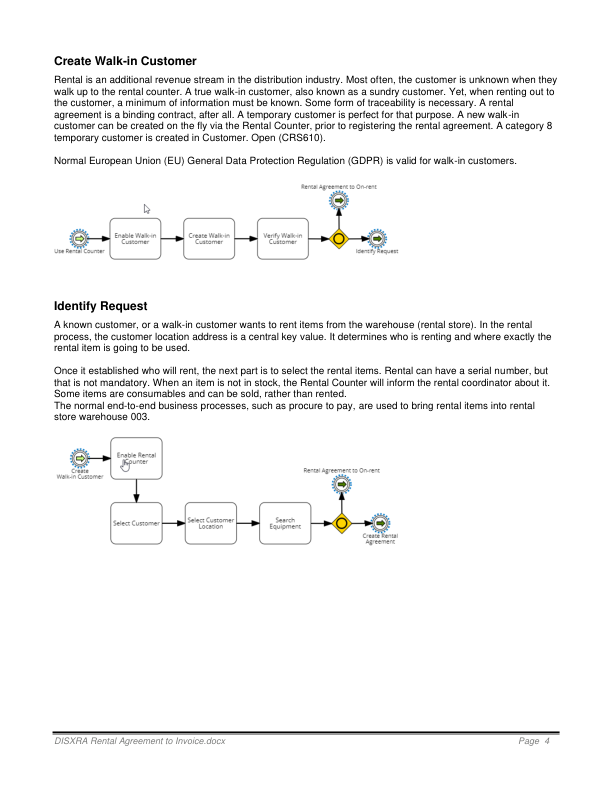

Page 4 analysis:
task='Analyze the content of page 4' objective='Extract and summarize key processes related to creating a walk-in customer and identifying rental requests.' expected_result='A clear outline of the processes involved in creating a walk-in customer and identifying rental requests based on the provided flowchart and textual context.' tables=[] number_of_diagrams=2 diagrams=[DiagramContent(title='Create Walk-in Customer Process', description='Flowchart demonstrating the steps to create a walk-in customer.', nodes=[Node(label='Use Rental Counter'), Node(label='Enable Walk-in Customer'), Node(label='Create Walk-in Customer'), Node(label='Verify Walk-in Customer'), Node(label='Identify Request')], edges=[Edge(sources=['Use Rental Counter'], targets=['Enable Walk-in Customer'], weight=None, label=None, condition=None), Edge(sources=['Enable Walk-in Customer'], targets=['Create Walk-in Customer'], weight=None, label=None, condition=None), Edge(sources=['Create Walk-in Customer'

In [174]:
diagrams = response.diagrams

import json  # Add this import if not already present

diagrams = response.diagrams

string_diagrams = ""
for diagram in diagrams:
    diagram_string = json.dumps(diagram.model_dump())  # Convert dictionary to JSON string
    string_diagrams += diagram_string + "\n"
    
new_response = extract_image_info(4, context=string_diagrams)

In [175]:
for index, gram in enumerate(response.diagrams):
    print(f"Diagram {index + 1}:")
    print(f"Title: {gram.title}")
    print(f"Description: {gram.description}")
    
    print("Nodes:")
    for node in gram.nodes:
        print(f"  - Node Label: {node.label}")
    
    print("Edges:")
    for edge in gram.edges:
        # Handle multiple sources and targets
        sources = ", ".join(edge.sources)
        targets = ", ".join(edge.targets)
        condition = f" (Condition: {edge.condition})" if edge.condition else ""
        
        print(f"  - Sources: {sources}")
        print(f"    Targets: {targets}")
        print(f"    Weight: {edge.weight}")
        print(f"    Label: {edge.label}{condition}")
    print("\n")

Diagram 1:
Title: Create Walk-in Customer Process
Description: Flowchart demonstrating the steps to create a walk-in customer.
Nodes:
  - Node Label: Use Rental Counter
  - Node Label: Enable Walk-in Customer
  - Node Label: Create Walk-in Customer
  - Node Label: Verify Walk-in Customer
  - Node Label: Identify Request
Edges:
  - Sources: Use Rental Counter
    Targets: Enable Walk-in Customer
    Weight: None
    Label: None
  - Sources: Enable Walk-in Customer
    Targets: Create Walk-in Customer
    Weight: None
    Label: None
  - Sources: Create Walk-in Customer
    Targets: Verify Walk-in Customer
    Weight: None
    Label: None
  - Sources: Verify Walk-in Customer
    Targets: Identify Request
    Weight: None
    Label: None


Diagram 2:
Title: Identify Request Process
Description: Flowchart outlining the steps needed to identify a customer's rental request.
Nodes:
  - Node Label: Walk-in Customer
  - Node Label: Enable Rental Customer
  - Node Label: Select Customer
  - Node

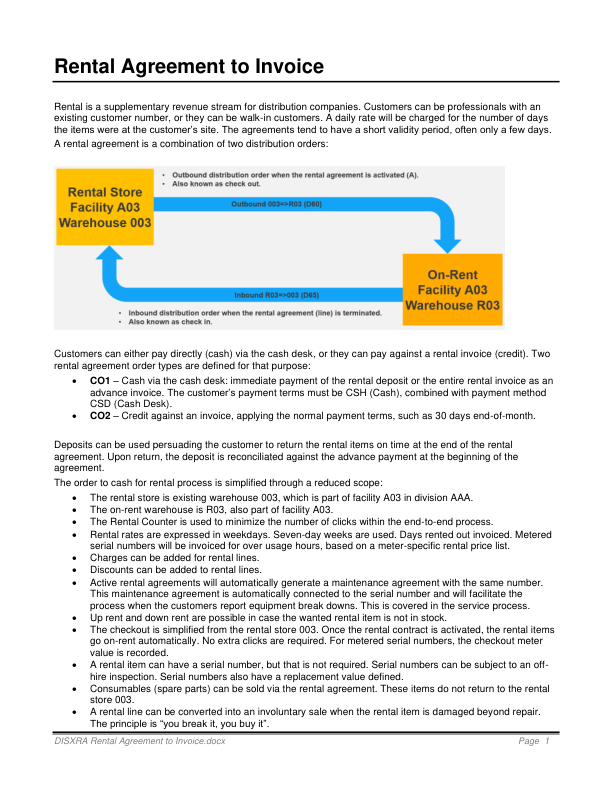

KeyboardInterrupt: 

In [84]:
# Iterate over each page and analyze content
for page_num, page_text in enumerate(pdf_text, start=1):
    # Convert the page to a base64 image
    base64_image = pdf_page_to_base64(pdf_path, page_num)
    display(IPImage(data=base64.b64decode(base64_image)))

    # Define the query
    query = f"Analyze the content of page {page_num}"

    # Create the message with text and image
    message = HumanMessage(
        content=[
            {"type": "text", "text": query},
            {"type": "text", "text": page_text},
            {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"},
            },
        ],
    )
    # Query the model
    response = llm_with_struct.invoke([message])
    print(f"Page {page_num} analysis:\n{response}\n")